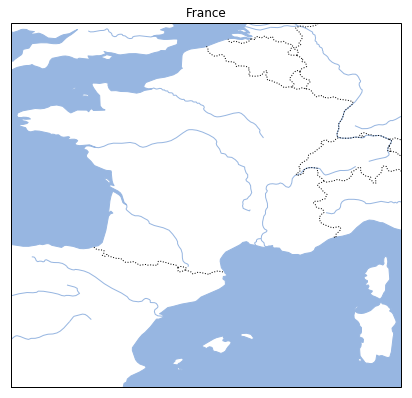

In [28]:
import cartopy.feature as cfeature

def carte_france(figsize=(7, 7)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent([-5, 10, 38, 52])

    ax.add_feature(cfeature.OCEAN.with_scale('50m'))
    ax.add_feature(cfeature.RIVERS.with_scale('50m'))
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':')
    ax.set_title('France');
    return ax



In [31]:
from pyensae import download_data
try:
    download_data("GEOFLA_2-1_DEPARTEMENT_SHP_LAMB93_FXX_2015-12-01.7z",
              website="https://wxs-telechargement.ign.fr/oikr5jryiph0iwhw36053ptm/telechargement/inspire/" + \
              "GEOFLA_THEME-DEPARTEMENTS_2015_2$GEOFLA_2-1_DEPARTEMENT_SHP_LAMB93_FXX_2015-12-01/file/")
except Exception as e:
    # au cas le site n'est pas accessible
    download_data("GGEOFLA_2-1_DEPARTEMENT_SHP_LAMB93_FXX_2015-12-01.7z", website="xd")

In [33]:
from pyquickhelper.filehelper import un7zip_files
try:
    un7zip_files("GEOFLA_2-1_DEPARTEMENT_SHP_LAMB93_FXX_2015-12-01.7z", where_to="shapefiles")
    departements = 'shapefiles/GEOFLA_2-1_DEPARTEMENT_SHP_LAMB93_FXX_2015-12-01/GEOFLA/1_DONNEES_LIVRAISON_2015/' + \
                   'GEOFLA_2-1_SHP_LAMB93_FR-ED152/DEPARTEMENT/DEPARTEMENT.shp'
except FileNotFoundError as e:
    # Il est possible que cette instruction ne fonctionne pas.
    # Dans ce cas, on prendra une copie de ce fichier.
    import warnings
    warnings.warn("Plan B parce que " + str(e))
    download_data("DEPARTEMENT.zip")
    departements = "DEPARTEMENT.shp"

import os
if not os.path.exists(departements):
    raise FileNotFoundError("Impossible de trouver '{0}'".format(departements))

In [41]:
import math

def lambert932WGPS(lambertE, lambertN):

    class constantes:
        GRS80E = 0.081819191042816
        LONG_0 = 3
        XS = 700000
        YS = 12655612.0499
        n = 0.7256077650532670
        C = 11754255.4261

    delX = lambertE - constantes.XS
    delY = lambertN - constantes.YS
    gamma = math.atan(-delX / delY)
    R = math.sqrt(delX * delX + delY * delY)
    latiso = math.log(constantes.C / R) / constantes.n
    sinPhiit0 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * math.sin(1)))
    sinPhiit1 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit0))
    sinPhiit2 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit1))
    sinPhiit3 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit2))
    sinPhiit4 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit3))
    sinPhiit5 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit4))
    sinPhiit6 = math.tanh(latiso + constantes.GRS80E * math.atanh(constantes.GRS80E * sinPhiit5))

    longRad = math.asin(sinPhiit6)
    latRad = gamma / constantes.n + constantes.LONG_0 / 180 * math.pi

    longitude = latRad / math.pi * 180
    latitude = longRad / math.pi * 180

    return longitude, latitude

lambert932WGPS(99217.1, 6049646.300000001), lambert932WGPS(1242417.2, 7110480.100000001)

((-4.1615802638173065, 41.303505287589545),
 (10.699505053975292, 50.85243395553585))

In [89]:
dictionnaire= {str(i):i/100.0 for i in range (95) }
dictionnaire 
L=[dictionnaire]

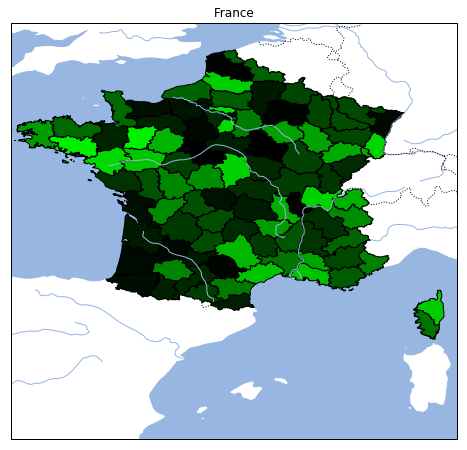

In [93]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
ax = carte_france((8,8))
from matplotlib.collections import LineCollection
import shapefile
import geopandas
from shapely.geometry import Polygon
from shapely.ops import cascaded_union, unary_union

shp = departements
r = shapefile.Reader(shp)
shapes = r.shapes()
records = r.records()
polys = []
colors = []

##########ICI insérer L la liste des dictionnaires correpondant aux réponses des questions

for j in range len(L):
    for i, (record, shape) in enumerate(zip(records, shapes)):
        
        alpha = L[j][str(records[i][1])]
        couleur = (0,alpha,0) ## On travaille en nuance de vert
        
        # les coordonnées sont en Lambert 93
        geo_points = [lambert932WGPS(x,y) for x, y in shape.points]
        if len(shape.parts) == 1:
            # Un seul polygone
            poly = Polygon(geo_points)
        else:
            # Il faut les fusionner.
            ind = list(shape.parts) + [len(shape.points)]
            pols = [Polygon(geo_points[ind[i]:ind[i+1]]) for i in range(0, len(shape.parts))]
            try:
                poly = unary_union(pols)
            except Exception as e:
                print("Cannot merge: ", record)
                print([_.length for _ in pols], ind)
                poly = Polygon(geo_points)
        polys.append(poly)
        colors.append(couleur)

    data = geopandas.GeoDataFrame(dict(geometry=polys, colors=colors))
    geopandas.plotting.plot_polygon_collection(ax, data['geometry'], facecolor=data['colors'],
                                               values=None, edgecolor='black');